In [1]:
# Check for TensorFlow and other dependencies
import caracal

if not caracal.TENSORFLOW_AVAILABLE:
    print("TensorFlow is not installed. Please install it with: pip install tensorflow")
else:
    print("TensorFlow is available. Proceeding with the example.")

from caracal.data import DataHandler
from caracal.core import KerasModelWrapper
from caracal.config import ModelConfig
from caracal.runners import ExperimentRunner
from caracal.loggers import BaseLogger

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd

2025-09-19 19:02:00.325825: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-19 19:02:00.355186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-19 19:02:00.785285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow is available. Proceeding with the example.


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Data Loading and Preparation ---
class MNISTDataHandler(DataHandler):
    """A custom DataHandler to load and preprocess the built-in MNIST dataset."""

    @property
    def data_type(self) -> str:
        return "image"

    @property
    def return_format(self) -> str:
        return "split_arrays"
        
    def __init__(self):
        # We don't need a data_path for this handler, but the parent class
        # expects one. We'll pass a placeholder and then override the validation.
        super().__init__(data_path="")

    def _validate_data_path(self):
        # We intentionally override the parent's validation because we are
        # loading a built-in dataset, not a file from disk.
        pass

    def load(self, validation_split: float = 0.2, **kwargs) -> dict:
        """Loads and preprocesses the MNIST dataset."""
        print("Loading MNIST data from TensorFlow...")
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

        # Reshape data for CNN input (batch, height, width, channels)
        X_train = np.expand_dims(X_train, axis=-1)
        X_test = np.expand_dims(X_test, axis=-1)

        # Normalize pixel values from [0, 255] to [0.0, 1.0]
        X_train = X_train.astype("float32") / 255.0
        X_test = X_test.astype("float32") / 255.0

        # Split training data into training and validation sets
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=validation_split, random_state=42
        )

        return {
            'train_data': (X_train, y_train),
            'val_data': (X_val, y_val),
            'test_data': (X_test, y_test)
        }

# Instantiate our custom data handler
mnist_handler = MNISTDataHandler()

In [3]:
# --- Model Definition ---
def create_simple_cnn(config: ModelConfig) -> KerasModelWrapper:
    """Builds a simple CNN for MNIST classification."""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return KerasModelWrapper(model)

# --- Model Configuration ---
model_config = ModelConfig({
    'epochs': 5,
    'batch_size': 32,
    'learning_rate': 0.001
})

Loading and preparing data...
Loading MNIST data from TensorFlow...
       0/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

2025-09-19 19:02:07.036382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-19 19:02:07.095874: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-19 19:02:07.098508: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 15s 1us/step
Starting Variability Study for 3 runs.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-19 19:02:22.951445: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-19 19:02:22.952874: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus

 - Training model 1...


I0000 00:00:1758308544.021936     206 service.cc:145] XLA service 0x72b638004b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758308544.021958     206 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-09-19 19:02:24.034404: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-19 19:02:24.105312: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1758308544.996210     206 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9887 - loss: 0.0386
 - Run 1 completed.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 - Training model 2...
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9897 - loss: 0.0315  
 - Run 2 completed.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 - Training model 3...
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9884 - loss: 0.0339   
 - Run 3 completed.
--------------------------------------------------

Experiment Complete: Summary of Final Results
Variability Study Results
Number of runs: 3
Available metrics: compile_metrics, epoch, loss, run_num, train_accuracy, train_loss, val_accuracy, val_loss

Final Validation Accuracy:
  Mean: 0.9879
  Std:  0.0008
  Min:  0.9868
  Max:  0.9887

Final Metrics DataFrame:
   run_id run_name  final_val_accuracy  final_train_accuracy  \
0       1    run_1            0.988083              0.993688   
1       2    run_2            0.988750              0.993583   
2       3    run_3            0.986750              0.993771   

   final_train_loss  final_val_loss  final_run_num  final_epoch  test_loss  \
0          0.020035        0.040358              1            5   0.038556   
1          0.019447        0.038553              2            5   0.031472   
2          0.019608    

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


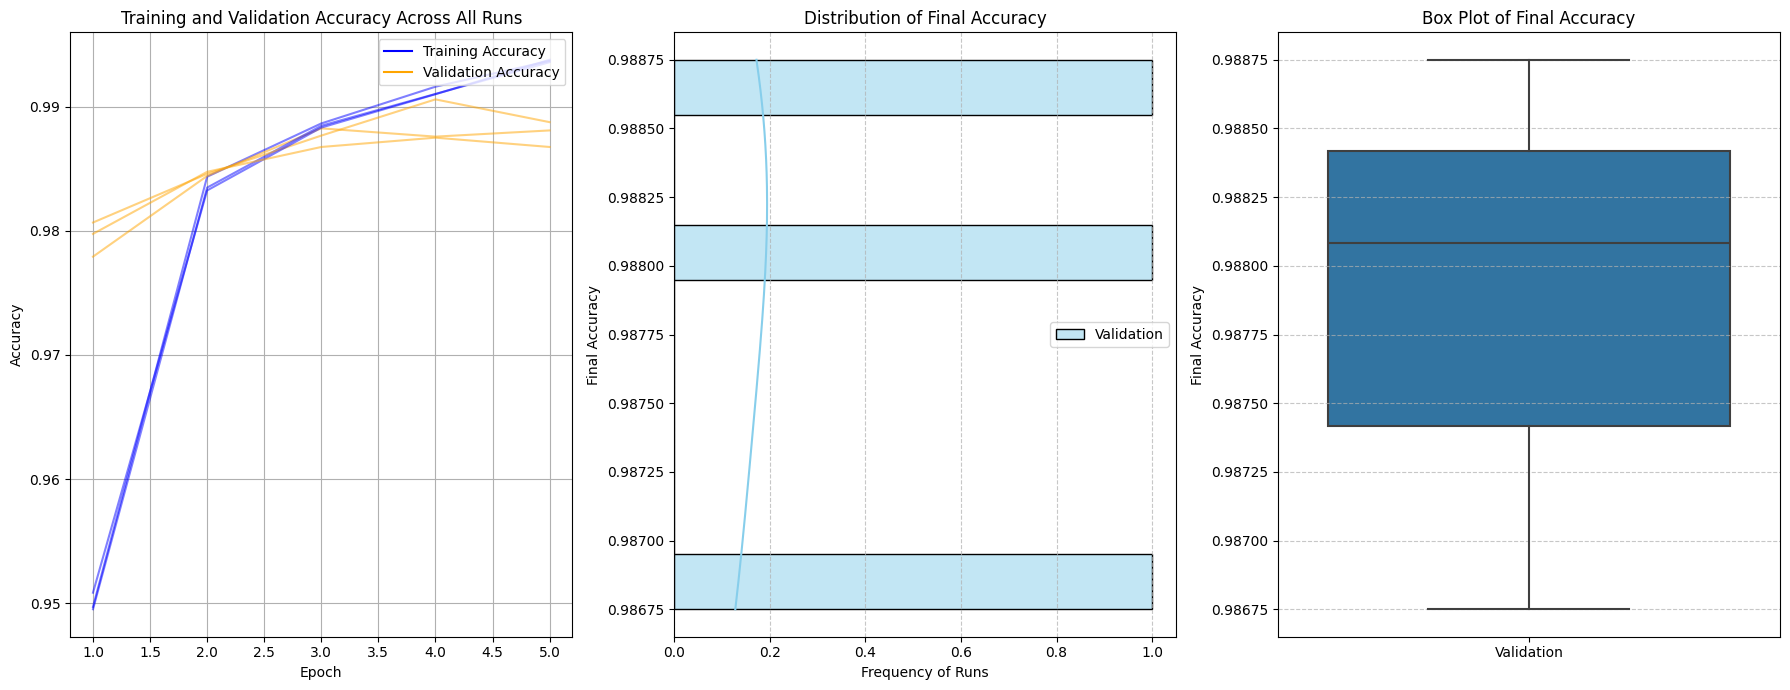


Performing Statistical Comparison of Runs...

Overall Statistical Test Result:
Test Name: Kruskal-Wallis H-Test
Statistic: 2.0000
P-value: 0.3679
Conclusion: There is no statistically significant difference between the runs.


In [4]:
# --- Run the Experiment ---
# Run a variability study with 3 runs
study_results = caracal.run_variability_study(
    model_builder=create_simple_cnn,
    data_handler=mnist_handler,
    model_config=model_config,
    num_runs=3,
    logger=BaseLogger()
)

# Print a summary of the results
print("\n" + "="*50)
print("Experiment Complete: Summary of Final Results")
print(study_results.summarize())

# Get a DataFrame of the final metrics for a more detailed view
results_df = study_results.to_dataframe()
print("\nFinal Metrics DataFrame:")
print(results_df)

# --- Analysis ---
# 5.1. Plotting the training histories
all_histories = study_results.all_runs_metrics
from caracal.plotting import plot_variability_summary

print("\nPlotting Variability Summary...")
plot_variability_summary(
    all_runs_metrics_list=all_histories,
    final_metrics_series=study_results.final_val_accuracies,
    metric='accuracy',
    show_boxplot=True
)

# 5.2. Statistical Comparison of Runs
print("\nPerforming Statistical Comparison of Runs...")
statistical_comparison = study_results.compare_models_statistically(
    metric_name='val_accuracy'
)

overall_result = statistical_comparison['overall_test']

print("\nOverall Statistical Test Result:")
print(f"Test Name: {overall_result.test_name}")
print(f"Statistic: {overall_result.statistic:.4f}")
print(f"P-value: {overall_result.p_value:.4f}")

if overall_result.is_significant():
    print("Conclusion: There is a statistically significant difference between the runs.")
else:
    print("Conclusion: There is no statistically significant difference between the runs.")